In [1]:
import numpy as np
import torch
import torch.distributions as dist
import matplotlib.pyplot as plt

from random_feature_gp import (generate_rff,
    bayesian_linear_model_loss, 
    bayesian_censored_model_loss, 
    fit_laplace_posterior, 
    laplace_predictive)

In [2]:
MAX_VALUE = 0.0

def noise_free_target(x):
    y = (x-2)*10
    return y * torch.sin(y) / 2

def oracle(x):
    return torch.clamp_max(noise_free_target(x) + torch.randn(x.shape) , 0.0)

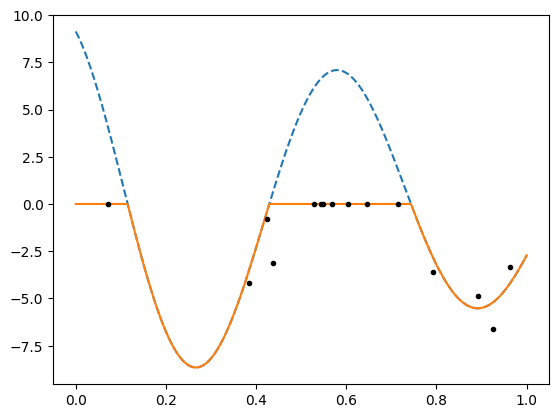

In [3]:
N_init = 15
np.random.seed(0)
x = torch.FloatTensor(np.random.rand(N_init))
torch.sort(x)
y = oracle(x)

features = generate_rff(1, M=100)

domain = torch.linspace(0, 1, 500)
plt.plot(domain, noise_free_target(domain), '--');
plt.plot(domain, torch.clamp_max(noise_free_target(domain), 0), '-');
plt.plot(x, y, 'k.')

In [4]:
def fit_linear_model():
    log_lengthscale = torch.tensor(-1.0).requires_grad_(True)
    # log_scale = torch.tensor(0.0).requires_grad_(True)
    log_noise = torch.tensor(0.0).requires_grad_(True)

    phi = features(x[:,None], log_lengthscale.exp())
    w_hat = torch.zeros(phi.shape[-1]).requires_grad_(True)


    # opt = torch.optim.Adagrad([w_hat, log_lengthscale, log_scale, log_noise], lr=1.0)
    opt = torch.optim.Adagrad([w_hat, log_lengthscale, log_noise], lr=0.1)
    tmp = []
    for i in range(20000):
        opt.zero_grad();
        phi = features(x[:,None], log_lengthscale.exp())
        loss = bayesian_linear_model_loss(w_hat, phi, y, log_noise.exp())
        loss.backward()
        opt.step()
        tmp.append(loss.item())

    plt.plot(tmp[200:]);

    with torch.no_grad():
        print("lengthscale: %0.4f\nnoise: %0.4f" % (log_lengthscale.exp(), log_noise.exp()))

    print("LOSS:", loss.item())
    
    return w_hat, log_lengthscale.exp().item(), log_noise.exp().item()

lengthscale: 0.1825
noise: 0.7314
LOSS: 109.45166778564453


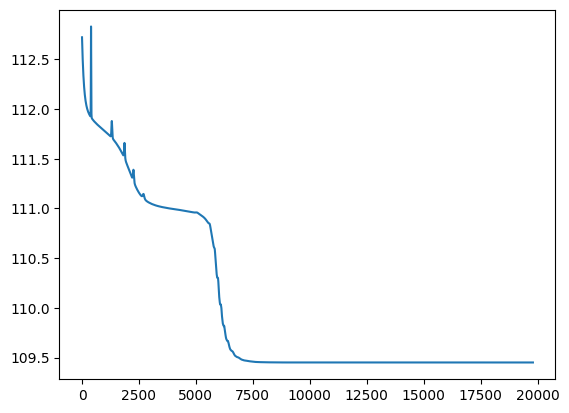

In [5]:
# Fit mode
w_hat_linear, lengthscale_linear, noise_linear = fit_linear_model()

# Laplace approximation to posterior variance
phi = features(x[:,None], lengthscale_linear)
H_linear = fit_laplace_posterior(w_hat_linear, 
                                 lambda w: bayesian_linear_model_loss(w, phi, y, noise_linear))


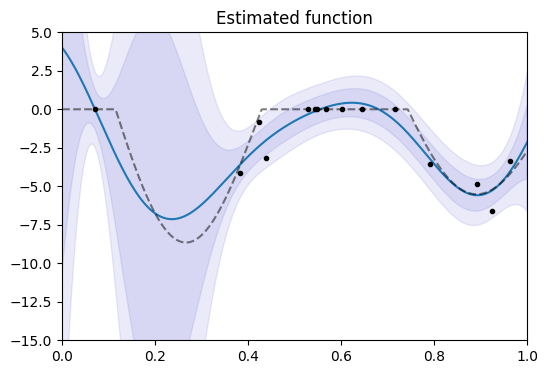

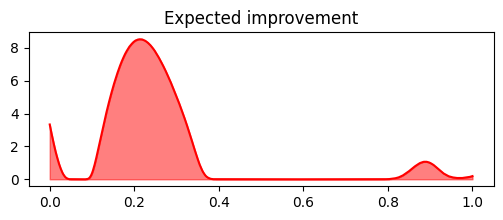

In [6]:
def plot_result(w_hat, H, lengthscale, noise, censored=False):

    phi_plot = features(domain[:,None], lengthscale)
    pred = laplace_predictive(phi_plot, w_hat, H)

    N_samples = 1000
#     pred_samples = pred.sample((N_samples,)) + dist.Normal(0, noise).sample((N_samples,domain.shape[0]))
    breakpoints = torch.linspace(0, 1, N_samples+1)[:-1]
    breakpoints = breakpoints + breakpoints[1] * torch.rand_like(breakpoints)
    pred_samples = dist.Normal(pred.loc, pred.scale + noise).icdf(breakpoints[:,None])

    if censored:
        c_pred = pred_samples > MAX_VALUE
        pred_samples[c_pred] = MAX_VALUE

    pred_median = np.median(pred_samples, axis=0)
    pred_quantiles = np.quantile(pred_samples, [0.025, 0.15, 0.85, 0.975], axis=0)

    plt.figure(figsize=(6, 4))
    plt.plot(domain, pred_median)

    plt.fill_between(domain, pred_quantiles[0], pred_quantiles[-1], alpha=0.1, color='#33c');
    plt.fill_between(domain, pred_quantiles[1], pred_quantiles[-2], alpha=0.1, color='#33c');

    plt.plot(x, y, 'k.');
    plt.plot(domain, noise_free_target(domain).clamp_max(MAX_VALUE), 'k--', alpha=0.5);
    plt.xlim(0, 1);
    plt.ylim(-15, 5);
    plt.title("Estimated function")
    
    plt.figure(figsize=(6, 2))
    plt.title("Expected improvement")
    EI =  -(pred_samples*(pred_samples < y.min()).float()).mean(0)
    plt.plot(domain, EI, 'r');
    plt.fill_between(domain, torch.zeros_like(domain), EI, color='r', alpha=0.5);
    
plot_result(w_hat_linear, H_linear, lengthscale_linear, noise_linear)

## Using a censored likelihood, what changes?

In [19]:
def fit_tobit_model():
    log_lengthscale = torch.tensor(0.0).requires_grad_(True)
    # log_scale = torch.tensor(0.0).requires_grad_(True)
    log_noise = torch.tensor(0.0).requires_grad_(True)

    phi = features(x[:,None], log_lengthscale.exp())
    w_hat = torch.zeros(phi.shape[-1]).requires_grad_(True)


    # opt = torch.optim.Adagrad([w_hat, log_lengthscale, log_scale, log_noise], lr=1.0)
    # Note needs much smaller learning rate…!
    opt = torch.optim.Adagrad([w_hat, log_lengthscale, log_noise], lr=0.05)
    tmp = []
    for i in range(20000):
        opt.zero_grad();
        phi = features(x[:,None], log_lengthscale.exp())
        loss = bayesian_censored_model_loss(w_hat, phi, y, log_noise.exp(), MAX_VALUE=MAX_VALUE)
        loss.backward()
        opt.step()
        tmp.append(loss.item())

    plt.plot(tmp[200:]);

    with torch.no_grad():
        print("lengthscale: %0.4f\nnoise: %0.4f" % (log_lengthscale.exp(), log_noise.exp()))

    print("LOSS:", loss.item())
    
    return w_hat, log_lengthscale.exp().detach(), log_noise.exp().detach()

lengthscale: 0.1807
noise: 1.0152
LOSS: 102.90312194824219


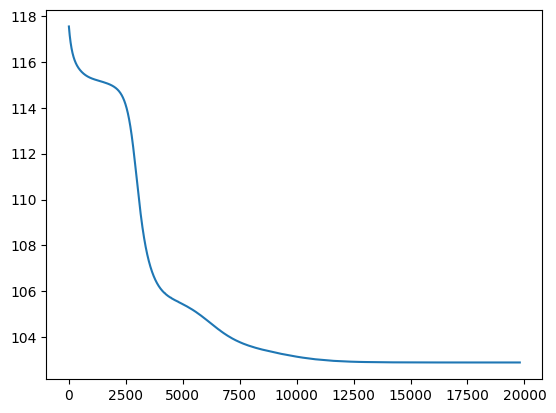

In [20]:
# Fit mode
w_hat_tobit, lengthscale_tobit, noise_tobit = fit_tobit_model()

# Laplace approximation to posterior
phi = features(x[:,None], lengthscale_tobit)
H_tobit = fit_laplace_posterior(w_hat_tobit,
                                lambda w: bayesian_censored_model_loss(w, phi, y, noise_tobit, MAX_VALUE=MAX_VALUE))


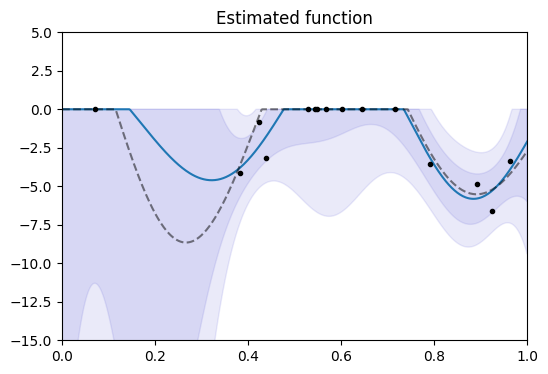

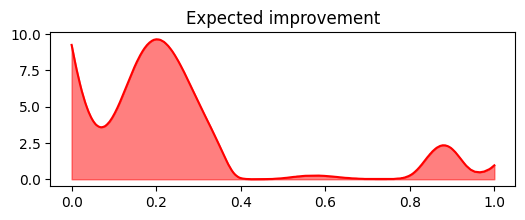

In [22]:
plot_result(w_hat_tobit, H_tobit, lengthscale_tobit, noise_tobit, censored=True)